In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import pearsonr

degs_all = pickle.load(open('../../results/degs_all.pkl', 'rb'))
exclude_genes = ['GARS', 'WDR61', 'C12orf45', 'INTS2', 'POLR2B', 'ZNF720', 'PRELID3B', 'C5orf30', 'SPATA5L1']
def read_metric(path, dataset, method):
    with open(path, 'rb') as f:
        dict_split = pickle.load(f)
        split = {}
        for k, v in dict_split.items():
            # get perturbation condition key
            if any(gene in k for gene in exclude_genes):
                continue
            true, pred, ctrl, _ = v.values()
            if method == 'biolord':
                pert_key = k.split('_')[1]
            elif method == 'gears':
                if dataset == 'adamson':
                    pert_key = f'{k}+ctrl'
                else:
                    pert_key = k
            if dataset == 'norman':
                pert_key = '+'.join(sorted(pert_key.split('+')))
            
            # compute metrics
            de_idx = degs_all[dataset][pert_key]
            true = true[de_idx]
            pred = pred[de_idx]
            ctrl = ctrl[de_idx]
            mse_k = mse(true, pred)/mse(true, ctrl)
            pear_k = pearsonr(true-ctrl, pred-ctrl)[0]
            split[k] = {'NormMSE':mse_k, 'Pearson':pear_k}
        split = pd.DataFrame.from_dict(split, orient='index')
    return split

custom_palette = {
    'Scouter': '#EFC000FF',
    'biolord': '#0073C2FF',
    'GEARS': '#CD534CFF'
}

## Read results on `dixit` dataset

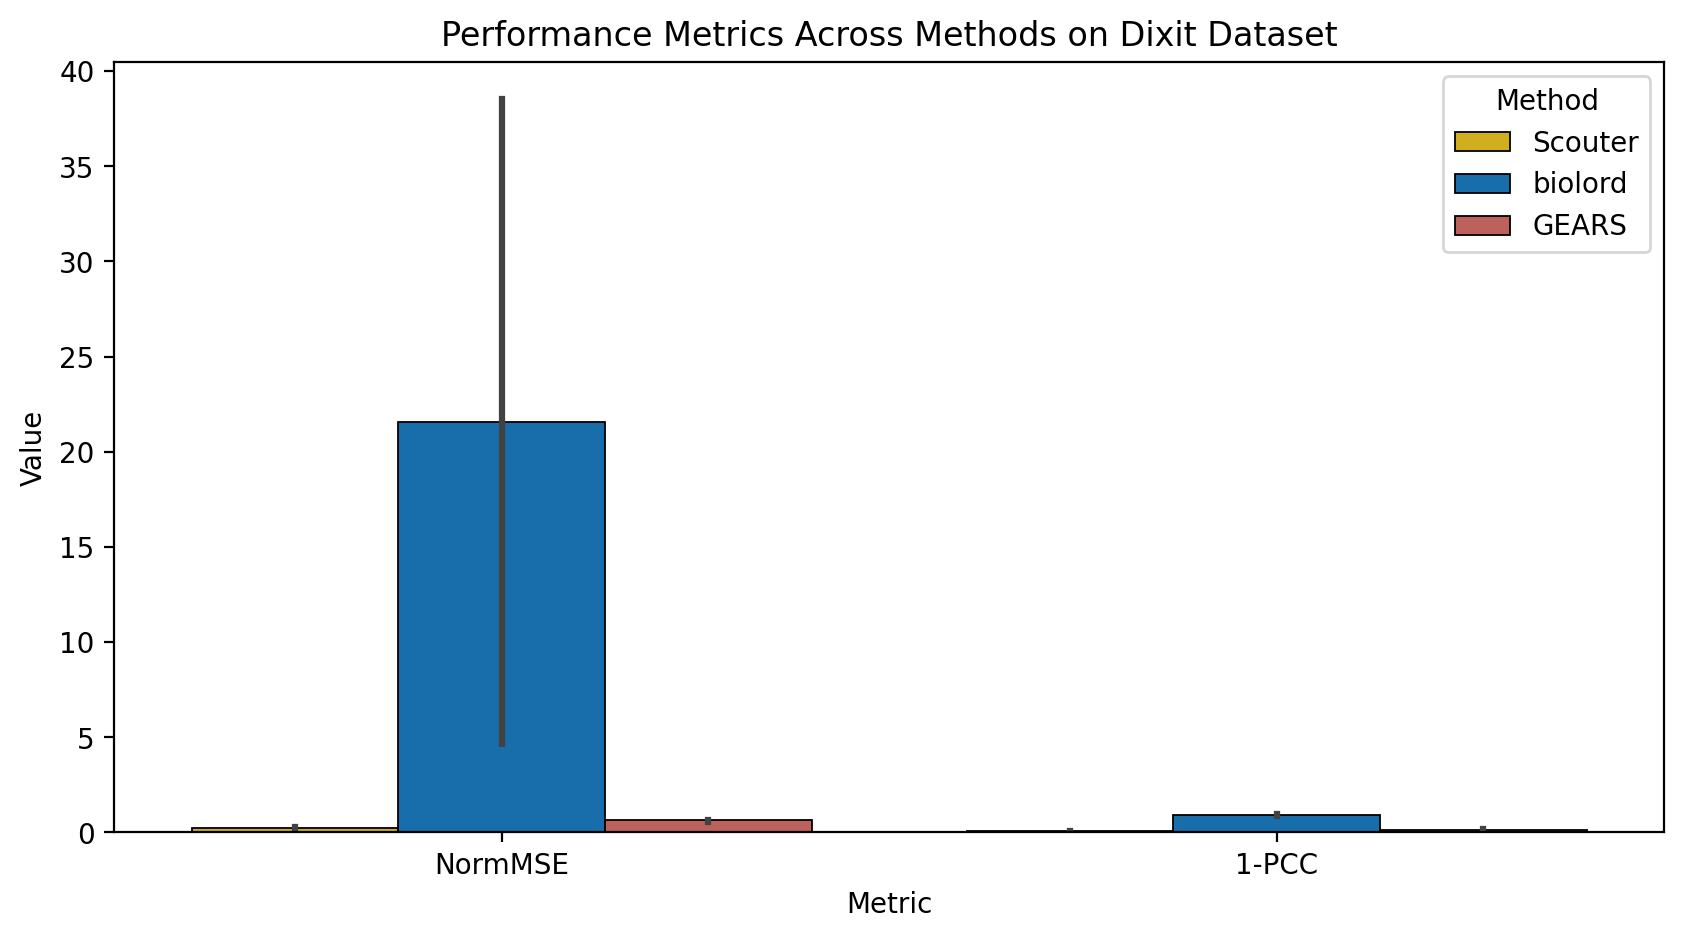

In [2]:
scouter_dixit = pd.read_csv('../../results/Scouter/Scouter_dixit_result.csv', index_col=0).assign(Method='Scouter').drop(columns=['Spearman'])
biolord_dixit = []; gears_dixit = []
for i in range(1,11):
    biolord = read_metric(f'../../results/biolord/biolord_dixit_{i}.pkl', 'dixit', 'biolord').assign(split=i)
    biolord_dixit.append(biolord)
    
    gears = read_metric(f'../../results/GEARS/GEARS_dixit_unseen_single_{i}.pkl', 'dixit', 'gears').assign(split=i)
    gears_dixit.append(gears)

biolord_dixit = pd.concat(biolord_dixit).assign(Method='biolord')
gears_dixit = pd.concat(gears_dixit).assign(Method='GEARS')
dixit_all = pd.concat([scouter_dixit, biolord_dixit, gears_dixit])
dixit_all['1-PCC'] = 1 - dixit_all['Pearson']
dixit_all[['NormMSE', '1-PCC', 'split', 'Method']].to_csv('../../results/dixit.csv')

plt.figure(figsize=(10,5), dpi=200)
metrics = ['NormMSE', '1-PCC']
melt_dixit = dixit_all.melt(id_vars=['Method'], value_vars=metrics, var_name='Metric', value_name='Value')
sns.barplot(data=melt_dixit, x='Metric', y='Value', hue='Method', edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("Performance Metrics Across Methods on Dixit Dataset")
plt.ylabel('Value')
plt.legend(title='Method', loc='upper right')
plt.show()

## Read results on `Adamson` dataset

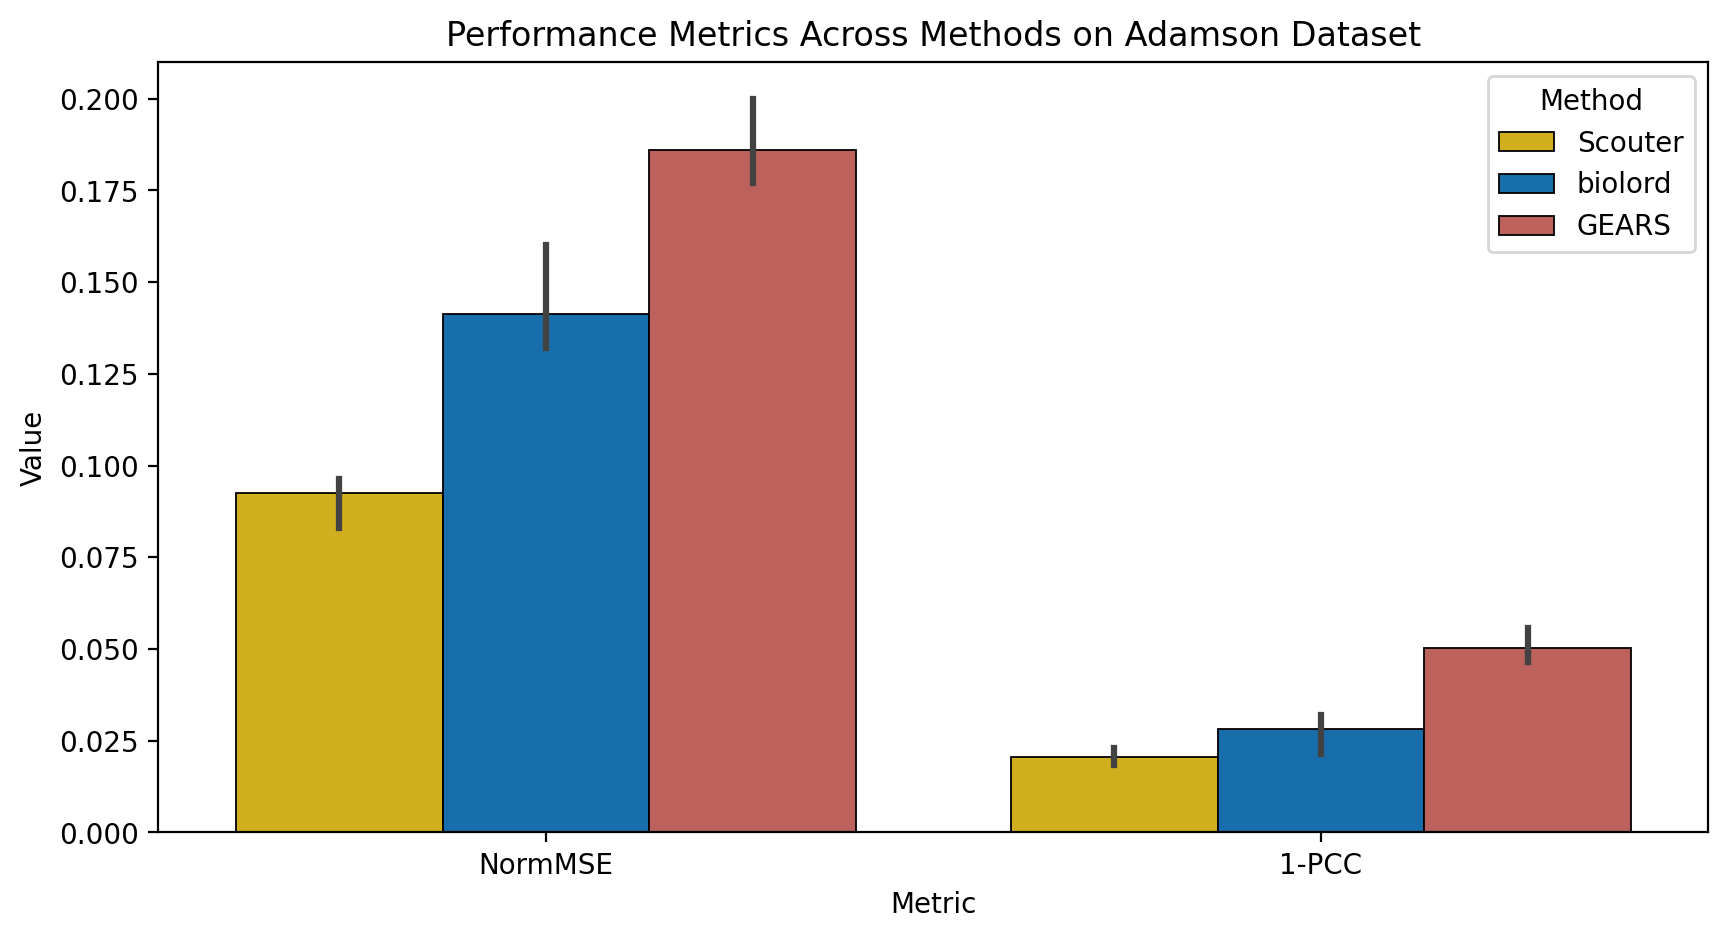

In [3]:
scouter_adamson = pd.read_csv('../../results/Scouter/Scouter_adamson_result.csv', index_col=0).assign(Method='Scouter').drop(columns=['Spearman'])
biolord_adamson = []; gears_adamson = []
for i in range(1,6):
    biolord = read_metric(f'../../results/biolord/biolord_adamson_{i}.pkl', 'adamson', 'biolord').assign(split=i)
    biolord_adamson.append(biolord)
    
    gears = read_metric(f'../../results/GEARS/GEARS_adamson_{i}.pkl', 'adamson', 'gears').assign(split=i)
    gears_adamson.append(gears)

biolord_adamson = pd.concat(biolord_adamson).assign(Method='biolord')
gears_adamson = pd.concat(gears_adamson).assign(Method='GEARS')
adamson_all = pd.concat([scouter_adamson, biolord_adamson, gears_adamson])
adamson_all['1-PCC'] = 1 - adamson_all['Pearson']
adamson_all[['NormMSE', '1-PCC', 'split', 'Method']].to_csv('../../results/adamson.csv')

plt.figure(figsize=(10,5), dpi=200)
metrics = ['NormMSE', '1-PCC']
melt_adamson = adamson_all.melt(id_vars=['Method'], value_vars=metrics, var_name='Metric', value_name='Value')
sns.barplot(data=melt_adamson, x='Metric', y='Value', hue='Method', edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("Performance Metrics Across Methods on Adamson Dataset")
plt.ylabel('Value')
plt.legend(title='Method', loc='upper right')
plt.show()

## Read results on `Norman` dataset

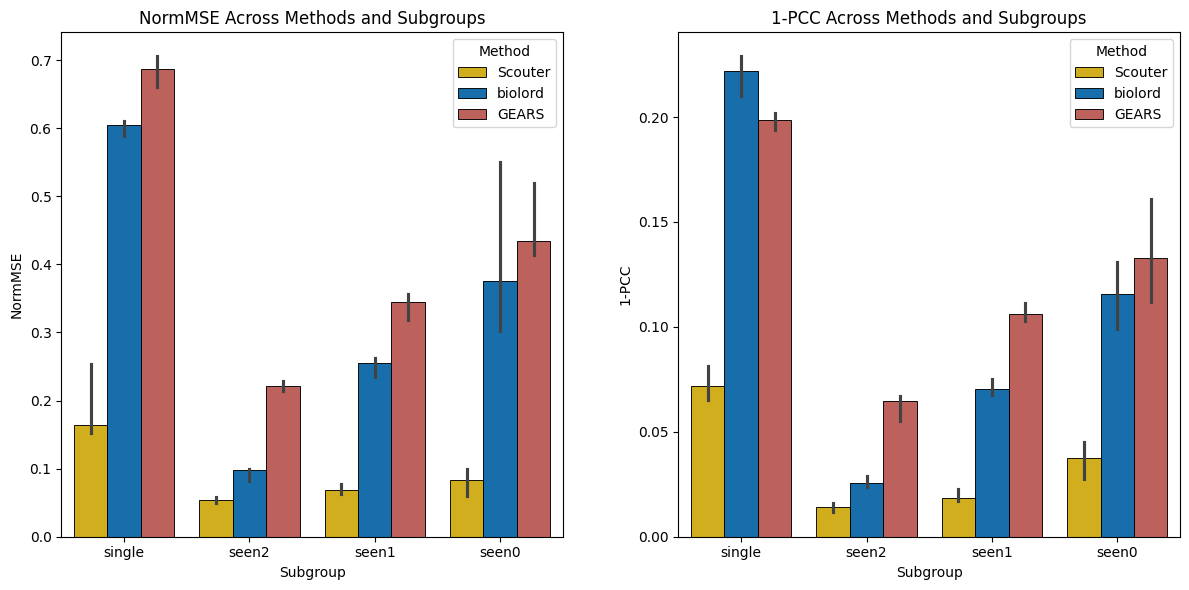

In [4]:
scouter_norman = pd.read_csv('../../results/Scouter/Scouter_norman_result.csv', index_col=0).assign(Method='Scouter').drop(columns=['Spearman'])
biolord_norman = []; gears_norman = []
for i in range(1,6):
    biolord_single = read_metric(f'../../results/biolord/biolord_norman_unseen_single_{i}.pkl', 'norman', 'biolord').assign(split=i, subgroup='single')
    biolord_seen0 = read_metric(f'../../results/biolord/biolord_norman_combo_seen0_{i}.pkl', 'norman', 'biolord').assign(split=i, subgroup='seen0')
    biolord_seen1 = read_metric(f'../../results/biolord/biolord_norman_combo_seen1_{i}.pkl', 'norman', 'biolord').assign(split=i, subgroup='seen1')
    biolord_seen2 = read_metric(f'../../results/biolord/biolord_norman_combo_seen2_{i}.pkl', 'norman', 'biolord').assign(split=i, subgroup='seen2')
    biolord_norman.append(pd.concat([biolord_single, biolord_seen0, biolord_seen1,biolord_seen2]))
    
    gears_single = read_metric(f'../../results/GEARS/GEARS_norman_unseen_single_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='single')
    gears_seen0 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen0_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen0')
    gears_seen1 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen1_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen1')
    gears_seen2 = read_metric(f'../../results/GEARS/GEARS_norman_combo_seen2_{i}.pkl', 'norman', 'gears').assign(split=i, subgroup='seen2')
    gears_norman.append(pd.concat([gears_single, gears_seen0, gears_seen1,gears_seen2]))

biolord_norman = pd.concat(biolord_norman).assign(Method='biolord')
gears_norman = pd.concat(gears_norman).assign(Method='GEARS')
norman_all = pd.concat([scouter_norman, biolord_norman, gears_norman])
norman_all['subgroup'] = pd.Categorical(norman_all['subgroup'], categories=['single', 'seen2', 'seen1', 'seen0'], ordered=True)
norman_all['1-PCC'] = 1 - norman_all['Pearson']
norman_all[['NormMSE', '1-PCC', 'split', 'subgroup', 'Method']].to_csv('../../results/norman.csv')

plt.figure(figsize=(12,6), dpi=100)
# First subplot - NormMSE
plt.subplot(1,2,1)
sns.barplot(data=norman_all, x='subgroup', y='NormMSE', hue='Method', 
            edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("NormMSE Across Methods and Subgroups")
plt.xlabel('Subgroup')
plt.ylabel('NormMSE')
plt.legend(title='Method')

# Second subplot - 1-PCC
plt.subplot(1,2,2)
sns.barplot(data=norman_all, x='subgroup', y='1-PCC', hue='Method',
            edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("1-PCC Across Methods and Subgroups") 
plt.xlabel('Subgroup')
plt.ylabel('1-PCC')
plt.legend(title='Method')

plt.tight_layout(w_pad=4)
plt.show()

## Read results on `Replogle K562` dataset`

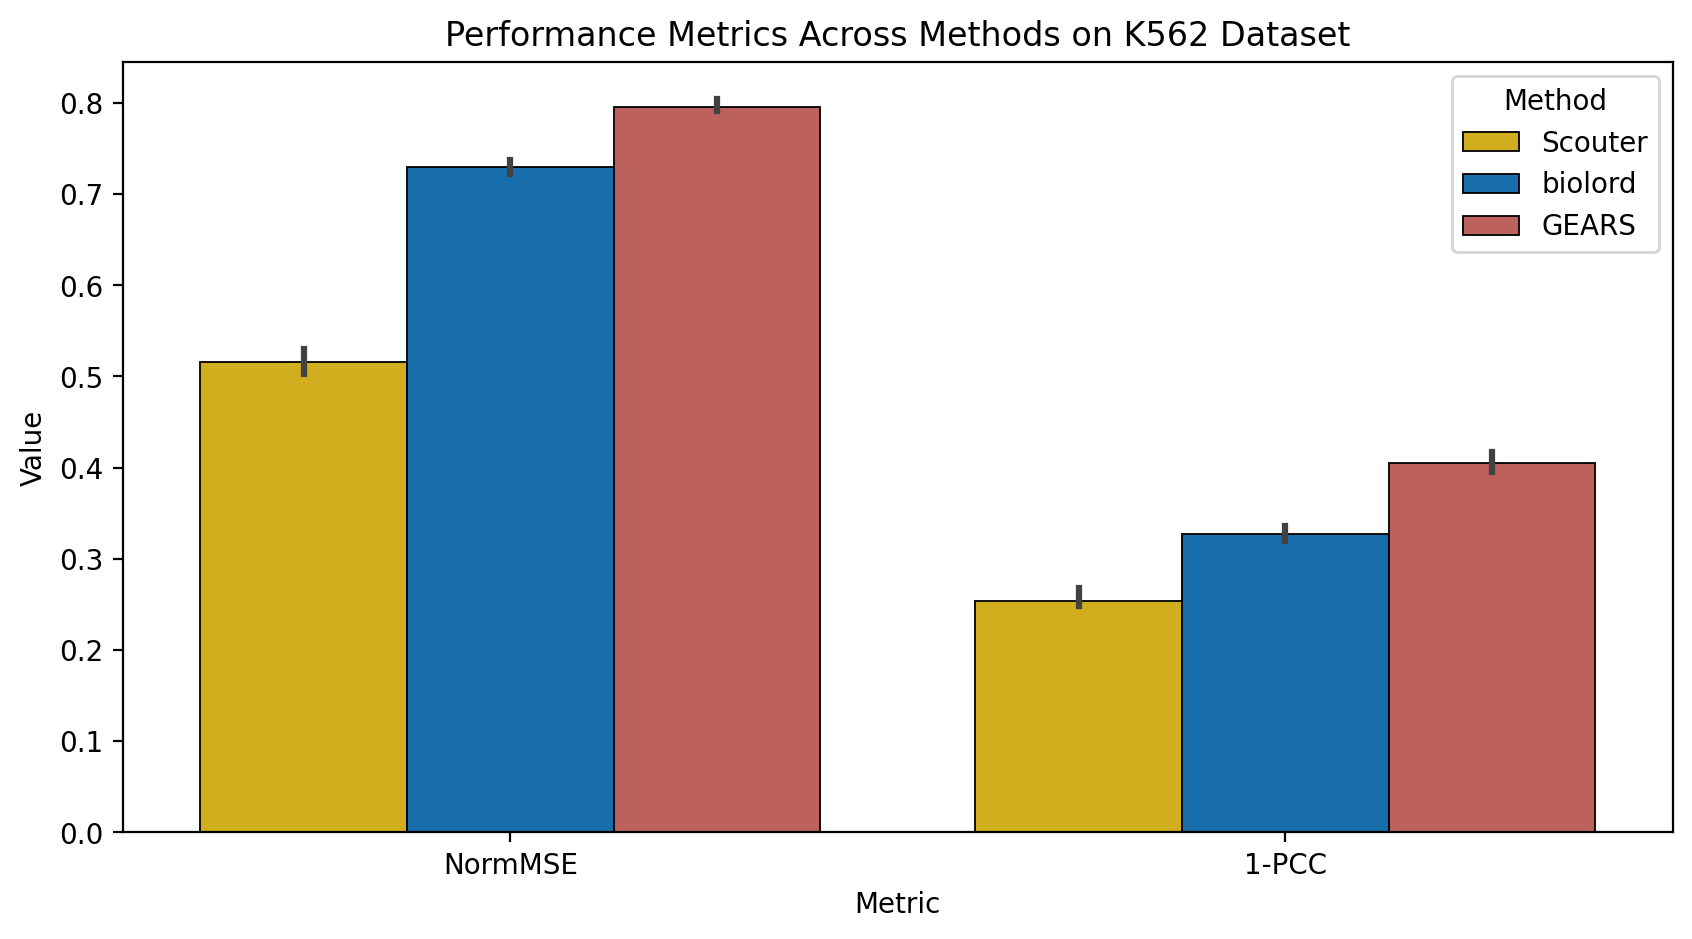

In [5]:
scouter_k562 = pd.read_csv('../../results/Scouter/Scouter_k562_result.csv', index_col=0).assign(Method='Scouter').drop(columns=['Spearman'])
biolord_k562 = []; gears_k562 = []
for i in range(1,6):
    biolord = read_metric(f'../../results/biolord/biolord_k562_{i}.pkl', 'k562', 'biolord').assign(split=i)
    biolord_k562.append(biolord)
    
    gears = read_metric(f'../../results/GEARS/GEARS_k562_unseen_single_{i}.pkl', 'k562', 'gears').assign(split=i)
    gears_k562.append(gears)

biolord_k562 = pd.concat(biolord_k562).assign(Method='biolord')
gears_k562 = pd.concat(gears_k562).assign(Method='GEARS')
k562_all = pd.concat([scouter_k562, biolord_k562, gears_k562])
k562_all['1-PCC'] = 1 - k562_all['Pearson']
k562_all[['NormMSE', '1-PCC', 'split', 'Method']].to_csv('../../results/k562.csv')

plt.figure(figsize=(10,5), dpi=200)
metrics = ['NormMSE', '1-PCC']
melt_k562 = k562_all.melt(id_vars=['Method'], value_vars=metrics, var_name='Metric', value_name='Value')
sns.barplot(data=melt_k562, x='Metric', y='Value', hue='Method', edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("Performance Metrics Across Methods on K562 Dataset")
plt.ylabel('Value')
plt.legend(title='Method', loc='upper right')
plt.show()

## Read results on `Replogle RPE1` dataset`

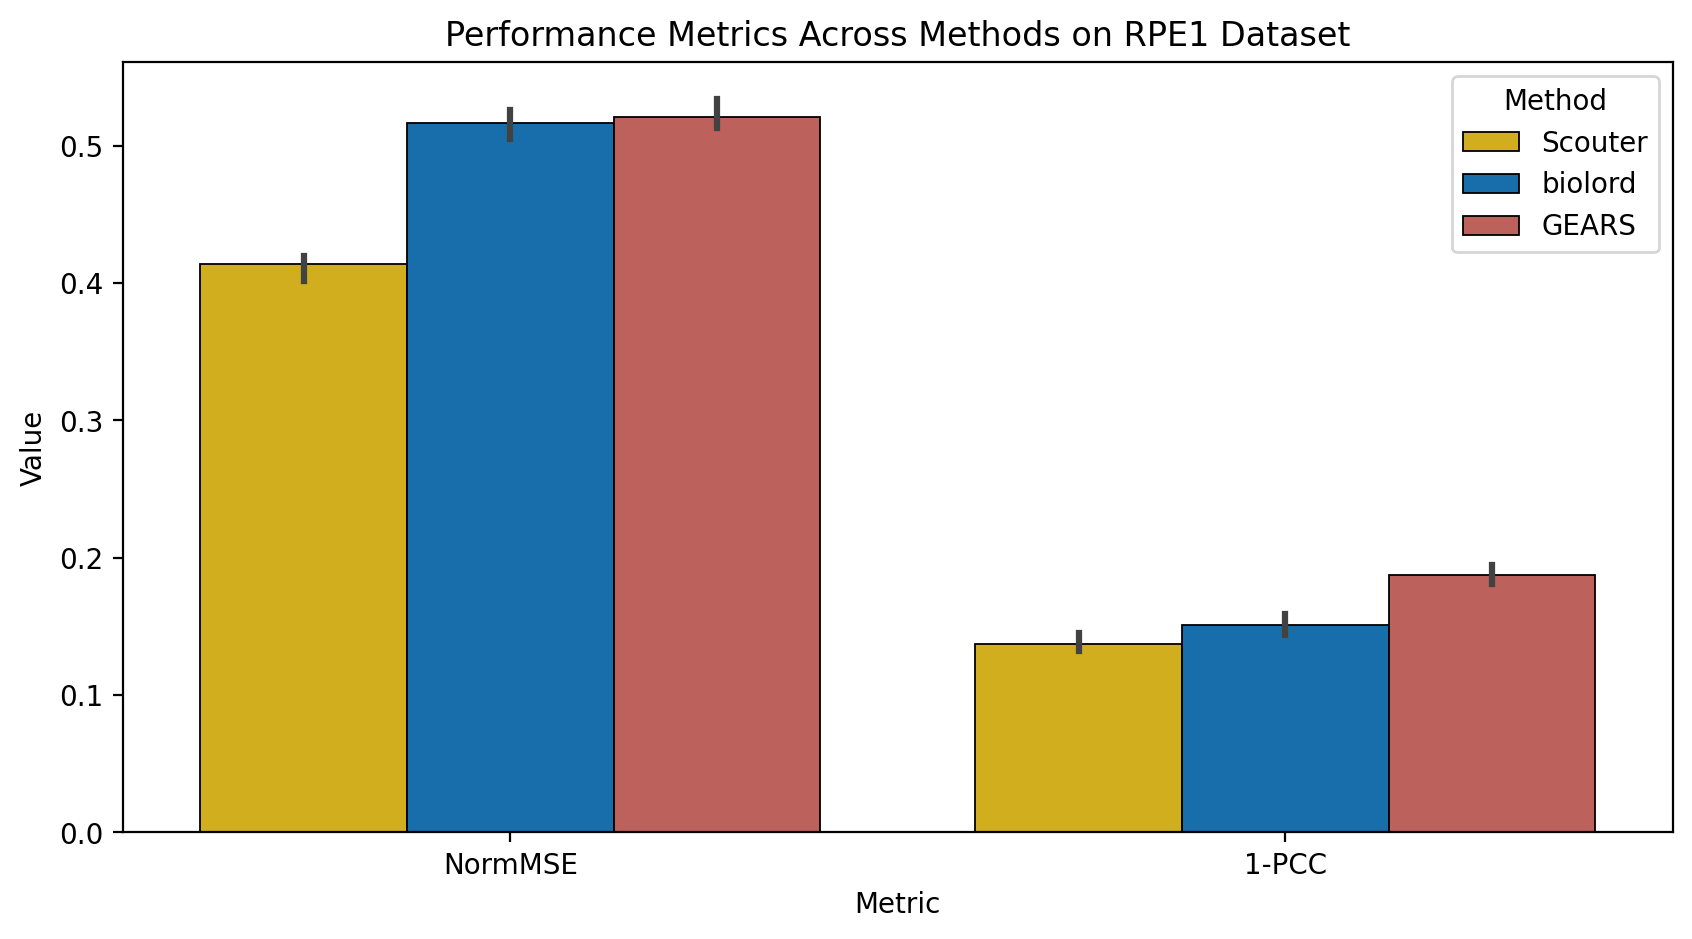

In [6]:
scouter_rpe1 = pd.read_csv('../../results/Scouter/Scouter_rpe1_result.csv', index_col=0).assign(Method='Scouter').drop(columns=['Spearman'])
biolord_rpe1 = []; gears_rpe1 = []
for i in range(1,6):
    biolord = read_metric(f'../../results/biolord/biolord_rpe1_{i}.pkl', 'rpe1', 'biolord').assign(split=i)
    biolord_rpe1.append(biolord)
    
    gears = read_metric(f'../../results/GEARS/GEARS_rpe1_unseen_single_{i}.pkl', 'rpe1', 'gears').assign(split=i)
    gears_rpe1.append(gears)

biolord_rpe1 = pd.concat(biolord_rpe1).assign(Method='biolord')
gears_rpe1 = pd.concat(gears_rpe1).assign(Method='GEARS')
rpe1_all = pd.concat([scouter_rpe1, biolord_rpe1, gears_rpe1])
rpe1_all['1-PCC'] = 1 - rpe1_all['Pearson']
rpe1_all[['NormMSE', '1-PCC', 'split', 'Method']].to_csv('../../results/rpe1.csv')

plt.figure(figsize=(10,5), dpi=200)
metrics = ['NormMSE', '1-PCC']
melt_rpe1 = rpe1_all.melt(id_vars=['Method'], value_vars=metrics, var_name='Metric', value_name='Value')
sns.barplot(data=melt_rpe1, x='Metric', y='Value', hue='Method', edgecolor='black', linewidth=0.65,
            errorbar=('ci', 50), estimator='median', palette=custom_palette)
plt.title("Performance Metrics Across Methods on RPE1 Dataset")
plt.ylabel('Value')
plt.legend(title='Method', loc='upper right')
plt.show()